In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates

import pandas as pd

from sw_functions import download_sc_dataset, get_trajectory, bin_distance
from usefulfunc import fit_model, power_law, double_gaussian, gaussian, poisson

/Users/nathan/.pyenv/versions/3.13.7/envs/sun_capstone/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get Mag / SW data
psp_mag, solo_mag = pd.read_pickle('data/psp_mag_rtn_1hour'), pd.read_pickle('data/solo_mag_rtn_1hour')
psp_sw, solo_sw = pd.read_pickle('data/psp_sweap_l3i_1hour'), pd.read_pickle('data/solo_swa_pas_grnd_mom_l2_1hour')

# Compute trajectory data
psp_traj_mag, psp_obstime_mag = get_trajectory(psp_mag, 'psp')
psp_traj_sw, psp_obstime_sw = get_trajectory(psp_sw, 'psp')

solo_traj_mag, solo_obstime_mag = get_trajectory(solo_mag, 'solo')
solo_traj_sw, solo_obstime_sw = get_trajectory(solo_sw, 'solo')

In [17]:
def create_ds(sc, year=None, years=None, dist_lim=None):
    """Create PSP or SolO complete dataset, global or by year.
    """
    if sc == 'psp':
        ds = psp_sw.join(psp_mag)
        ds['Distance'] = psp_traj_sw.radius.to('AU').value
        ds['lon'] = psp_traj_sw.lon.to('deg').value
        ds['lat'] = psp_traj_sw.lat.to('deg').value
        # Slice during Solo's Mission duration
        #start, end = '2020-4-15', '2025-5-31'
        #ds = ds[(ds.index >= start) & (ds.index <= end)]

    if sc == 'solo':
        ds = solo_sw.join(solo_mag)
        ds['Distance'] = solo_traj_sw.radius.to('AU').value
        ds['lon'] = solo_traj_sw.lon.to('deg').value
        ds['lat'] = solo_traj_sw.lat.to('deg').value

    if dist_lim:
        dist_min, dist_max = dist_lim
        ds = ds[(ds['Distance'] <= dist_max) & (ds['Distance'] >= dist_min)]

    if year:
        ds = ds[ds.index.year == year]

    if years:
        ds = ds[(ds.index.year >= years[0]) & (ds.index.year <= years[1])]

    return ds

# Scatter plots of $V_p$ vs Distance colormapped

In [6]:
def case_study(sc_name, year=None, dist_lim=None, vp_lim=None):

    dist_min, dist_max = dist_lim
    vp_min, vp_max = vp_lim

    fig, ax = plt.subplots(4, figsize=(10,20), dpi=100)

    sc = create_ds(sc_name, year)

    # Filter by distance
    sc = sc[(sc['Distance'] >= dist_min) & (sc['Distance'] <= dist_max)]
    sc = sc[(sc['Vp'] >= vp_min) & (sc['Vp'] <= vp_max)]

    # Magnetic Field
    for aa, param in zip(ax, ['total_B', 'B_r', 'B_t']):
        # Scatter plot and colorbar
        scatter = aa.scatter(sc['Distance'], sc['Vp'], c=sc[f'{param}'].abs(), cmap='plasma')
        plt.colorbar(scatter, label=f'{param} (nT)')

        # xlim and ylabel and inward ticks
        aa.set_xlim(sc['Distance'].min(), sc['Distance'].max())
        aa.set_ylabel('Vp (km/s)')
        aa.tick_params(direction='in')

    # Time Plot
    # Time into floats
    time_float = mdates.date2num(sc.index)

    # Plot scatter and colorbar
    scatter = ax[-1].scatter(sc['Distance'], sc['Vp'], c=time_float, cmap='Set1', edgecolor='k')
    cbar = plt.colorbar(scatter, label='Time')

    # Replace colorbar ticks with dates
    tick_locs = cbar.get_ticks()
    tick_labels = [mdates.num2date(t).strftime('%Y-%m-%d') for t in tick_locs]
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(tick_labels)

    # Xlim, labels and ticks
    ax[-1].set_xlim(sc['Distance'].min(), sc['Distance'].max())
    ax[-1].set_xlabel('Distance (AU)')
    ax[-1].set_ylabel('Vp (km/s)')
    ax[-1].tick_params(direction='in')

    if year:
        fig.suptitle(f'{sc_name.upper()} Solar Wind Speed at {dist_min}-{dist_max} AU in {year}', y=.89)
    else:
        fig.suptitle(f'{sc_name.upper()} Solar Wind Speed at {dist_min}-{dist_max} AU', y=.89)

    print('Time range', sc.index[0], 'to', sc.index[-1])

    plt.subplots_adjust(hspace=0)

    return fig, ax

Time range 2023-04-07 17:00:00 to 2024-10-03 17:00:00


(<Figure size 1000x2000 with 8 Axes>,
 array([<Axes: ylabel='Vp (km/s)'>, <Axes: ylabel='Vp (km/s)'>,
        <Axes: ylabel='Vp (km/s)'>,
        <Axes: xlabel='Distance (AU)', ylabel='Vp (km/s)'>], dtype=object))

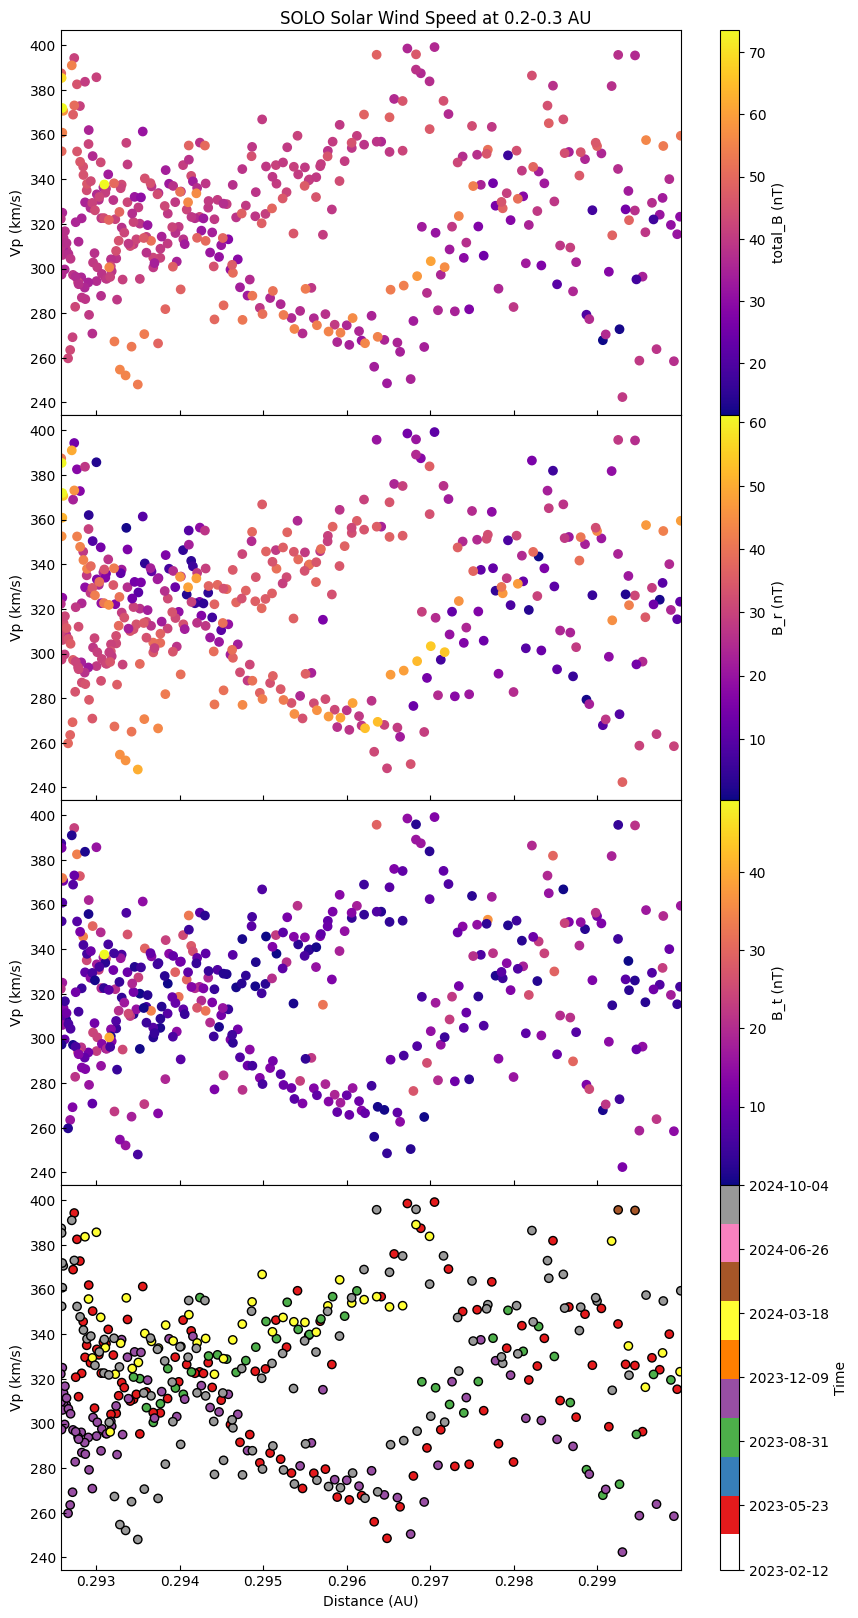

In [7]:
case_study('solo', dist_lim=(0.2, 0.3), vp_lim=(0,400))

# $V_p$ Histograms

In [45]:
def plot_histogram(sc, param, unit=None, dist_lim=(0, 1), year=None, vp_lim=None, years=None, xlims=None, bins=2000):

    # Create dataset
    ds = create_ds(sc, year, years)

    # Filter by distance and solar wind speed
    dist_min, dist_max = dist_lim
    data = ds[(ds['Distance'] <= dist_max) & (ds['Distance'] >= dist_min)]

    if vp_lim:
        vp_min, vp_max = vp_lim
        data = data[(data['Vp'] >= vp_min) & (data['Vp'] <= vp_max)]

    if sc == 'solo':
        edgecolor='blue'
        facecolor='tab:blue'
    
    if sc == 'psp':
        edgecolor = 'red'
        facecolor = 'tab:orange'

    # Create Figure and plot
    fig, ax = plt.subplots(figsize=(8,8), dpi=100)
    counts, bins, _ = ax.hist(data[f'{param}'], edgecolor=edgecolor, facecolor=facecolor, bins=np.linspace(0, np.max(ds[f'{param}']), bins), label=f'{sc.upper()} data')
    ax.text(0.83, 0.98, f'{'$\mu$':>3} = {np.mean(data[f'{param}']):.0f} {unit}\n{'$\sigma$':>3} = {np.std(data[f'{param}']):.0f} {unit}\n{'$\overline{x}$':>3} = {np.nanmedian(data[f'{param}']):.0f} {unit}', ha='left', va='top', transform=ax.transAxes)

    # xlim, labels and title
    ax.set_xlim(0, np.max(data[f'{param}']))
    ax.set_xlabel(f'{param} ({unit})')
    ax.set_ylabel('Counts')
    ax.legend()

    if year:
        fig.suptitle(f'Distribution of {param} between {dist_lim[0]} and {dist_lim[1]} AU in {year}', y=.91)
    elif years:
        fig.suptitle(f'Distribution of {param} between {dist_lim[0]} and {dist_lim[1]} AU during {years[0]}-{years[1]}', y=.91)
    else:
        fig.suptitle(f'Distribution of {param} between {dist_lim[0]} and {dist_lim[1]} AU over entire {sc.upper()} mission', y=.91)

    return fig, ax, counts, bins

<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\o'
/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_92111/246852990.py:25: SyntaxWarning: invalid escape sequence '\m'
  ax.text(0.83, 0.98, f'{'$\mu$':>3} = {np.mean(data[f'{param}']):.0f} {unit}\n{'$\sigma$':>3} = {np.std(data[f'{param}']):.0f} {unit}\n{'$\overline{x}$':>3} = {np.nanmedian(data[f'{param}']):.0f} {unit}', ha='left', va='top', transform=ax.transAxes)
/var/folders/j9/q8hqts053r57j7y11x4bv2_c0000gn/T/ipykernel_92111/246852990.py:25: SyntaxWarning: invalid escape sequence '\s'
  ax.text(0.83, 0.98, f'{'$\mu$':>3} = {np.mean(data[f'{param}']):.0f} {unit}\n{'$\sigma$':>3} = {np.std(data[f'{param}']):.0f} {unit}\n{'$\overline{x}$':>3} = {np.nanmedian(data[f'{param}'])

(0.0, 150.0)

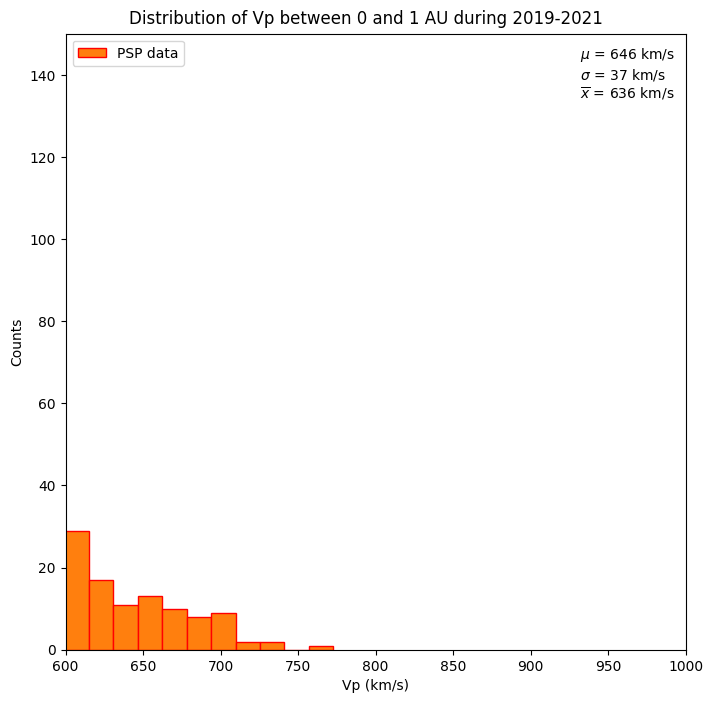

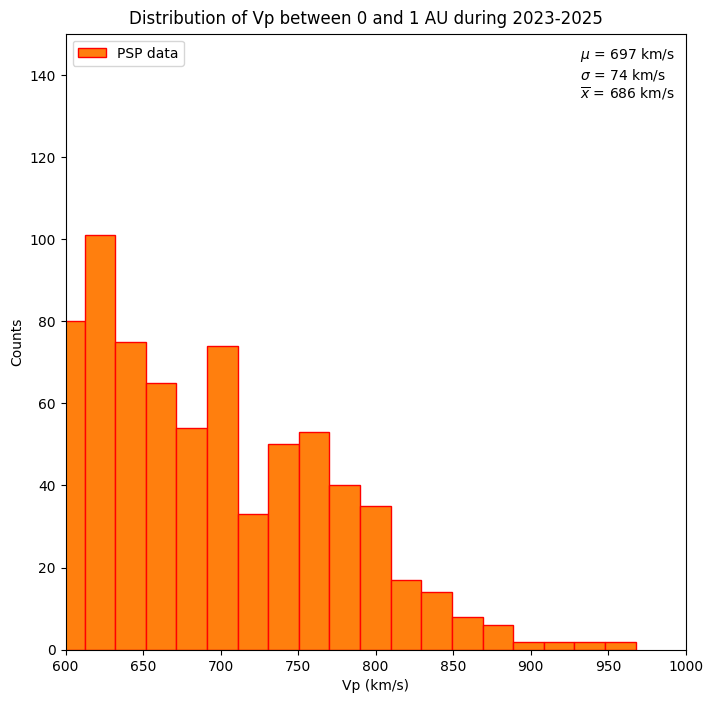

In [51]:
fig, ax, counts, bins = plot_histogram('psp', 'Vp', 'km/s', years=(2019, 2021), bins=50, vp_lim=(600, 1000));
ax.set_xlim(600, 1000)
ax.set_ylim(0, 150)
fig, ax, counts, bins = plot_histogram('psp', 'Vp', 'km/s', years=(2023, 2025), bins=50, vp_lim=(600, 1000));
ax.set_xlim(600, 1000)
ax.set_ylim(0, 150)

In [ ]:
fig, ax = plt.subplots

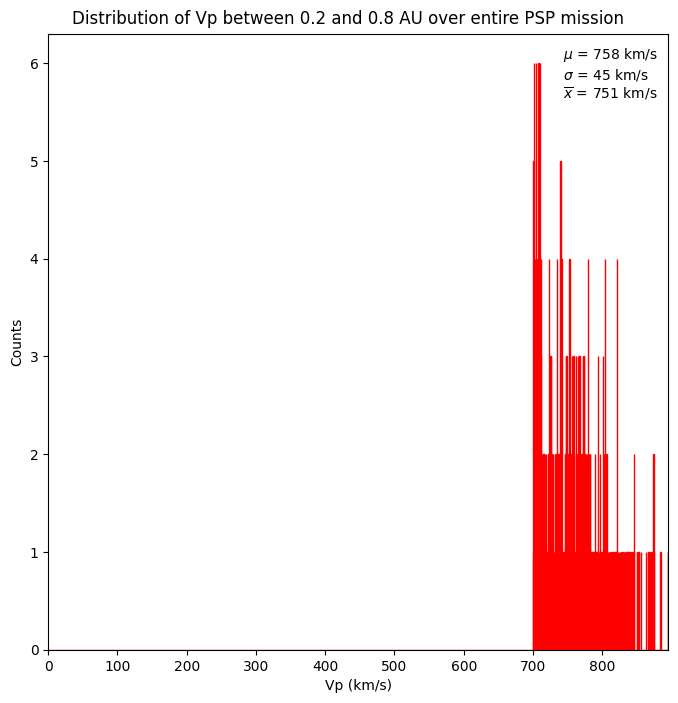

In [10]:
fig, ax, counts, bins = plot_histogram('psp', 'Vp', 'km/s', dist_lim=(0.2, 0.8), vp_lim=(700, 900));

/Users/nathan/Documents/Code/sun_capstone/usefulfunc.py:133: OptimizeWarning: Covariance of the parameters could not be estimated
  p_fit, pcov = curve_fit(fit_func, x, y, sigma=s)


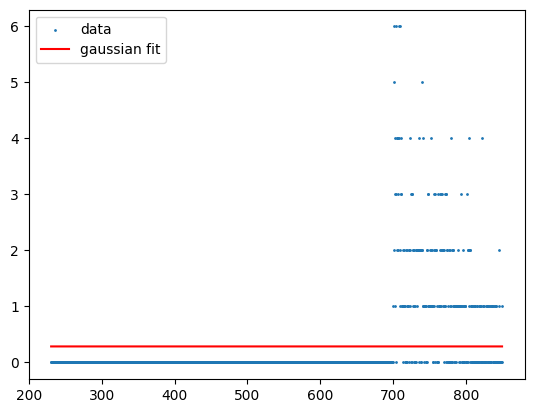

In [11]:
bin_centers = (bins[:-1] + bins[1:])/2

mask = (bin_centers > 230) & (bin_centers < 850)
masked_counts = counts[mask]
bin_centers = bin_centers[mask]

p_fit, e_fit, r2_val, _ = fit_model(gaussian, bin_centers, masked_counts)

plt.scatter(bin_centers, masked_counts, s=1, label='data')
plt.plot(bin_centers, gaussian(bin_centers, *p_fit), 'r', label='gaussian fit')
#plt.plot(bin_centers, gaussian(bin_centers, 400, 330, 100, 0), 'r')

plt.legend()

In [12]:
def plot_histograms(param, unit=None, year=None):

    # Create dataset
    solo = create_ds('solo', year)
    psp = create_ds('psp', year)

    # Bin data per 0.1 AU
    distance_bins = np.arange(0, 1.1, 0.1)
    solo['distance_bin'] = pd.cut(solo['Distance'], distance_bins)
    psp['distance_bin'] = pd.cut(psp['Distance'], distance_bins)

    # Create Figure
    fig, ax = plt.subplots(3, 3, figsize=(15,15), dpi=100)
    ax = ax.flatten()

    # Intervals
    intervals = [pd.Interval(round(i, 1), round(i+.1, 1), closed='right') for i in np.arange(0.1, 1, 0.1)]

    # Loop over each distance bin, lot a histogram for each
    for aa, interval in zip(ax, intervals):

        # Mask bin and get the data  
        select_bin_solo = solo['distance_bin'] == interval
        select_bin_psp = psp['distance_bin'] == interval

        distance_solo = solo['Distance'][select_bin_solo]
        distance_psp = psp['Distance'][select_bin_psp]

        solo_vp = solo[f'{param}'][select_bin_solo]
        psp_vp = psp[f'{param}'][select_bin_psp]

        bin_size = 300

        # Do not execute if the masked array is all nans
        if not np.isnan(solo_vp).all():
            aa.hist(solo_vp, edgecolor='b', facecolor='tab:blue', bins=np.linspace(0, np.max(solo[f'{param}']), bin_size), alpha=.4, label='solo')
            # Plot the histogram
        if not np.isnan(psp_vp).all():
            aa.hist(psp_vp, edgecolor='r', facecolor='tab:orange', bins=np.linspace(0, np.max(psp[f'{param}']), bin_size), alpha=.2, label='psp')

            # Remove Nans
            #data = pd.concat([bins, counts], axis=1).dropna()
            #x_clean = data.iloc[:, 0].values
            #y_clean = data.iloc[:, 1].values

            # Fit double gaussian
            #p_fit, e_fit, r_squared, res = fit_model(double_gaussian, bin_centers, counts, p0=[15, 400, 100, 4,700 , 100])
            # Plot
            #aa.plot(bin_centers, double_gaussian(bin_centers, *p_fit), 'r-')

            # Append fit data
            #fit_row = {'bin_start': d_min, 'bin_end':d_max, 'a': p_fit[0], 'b': p_fit[1], 'a_e': e_fit[0], 'b_e': e_fit[1], 'r_squared': r_squared}
            #fit_list.append(fit_row)

        # Set title, xlim and xlabel
        aa.set_title(f'{interval.left}-{interval.right} AU')
        aa.set_xlim(0, np.max(solo[f'{param}']))
        aa.set_xlabel(f'{param} ({unit})')
    
    handles = [Patch(facecolor='tab:blue', edgecolor='blue', label='SOLO'), Patch(facecolor='tab:orange', edgecolor='r', label='PSP')]

    fig.legend(handles=handles, loc='center', ncols=2, bbox_to_anchor=(.51, 0.07))

    if year:
        fig.suptitle(f'Distribution of {param} between 0.1 and 1 AU in {year}', y=.91)
    else:
        fig.suptitle(f'Distribution of {param} between 0.1 and 1 AU using entire SOLO and PSP mission range', y=.91)

    return fig, ax

(<Figure size 1500x1500 with 9 Axes>,
 array([<Axes: title={'center': '0.1-0.2 AU'}, xlabel='Vp (km/s)'>,
        <Axes: title={'center': '0.2-0.3 AU'}, xlabel='Vp (km/s)'>,
        <Axes: title={'center': '0.3-0.4 AU'}, xlabel='Vp (km/s)'>,
        <Axes: title={'center': '0.4-0.5 AU'}, xlabel='Vp (km/s)'>,
        <Axes: title={'center': '0.5-0.6 AU'}, xlabel='Vp (km/s)'>,
        <Axes: title={'center': '0.6-0.7 AU'}, xlabel='Vp (km/s)'>,
        <Axes: title={'center': '0.7-0.8 AU'}, xlabel='Vp (km/s)'>,
        <Axes: title={'center': '0.8-0.9 AU'}, xlabel='Vp (km/s)'>,
        <Axes: title={'center': '0.9-1.0 AU'}, xlabel='Vp (km/s)'>],
       dtype=object))

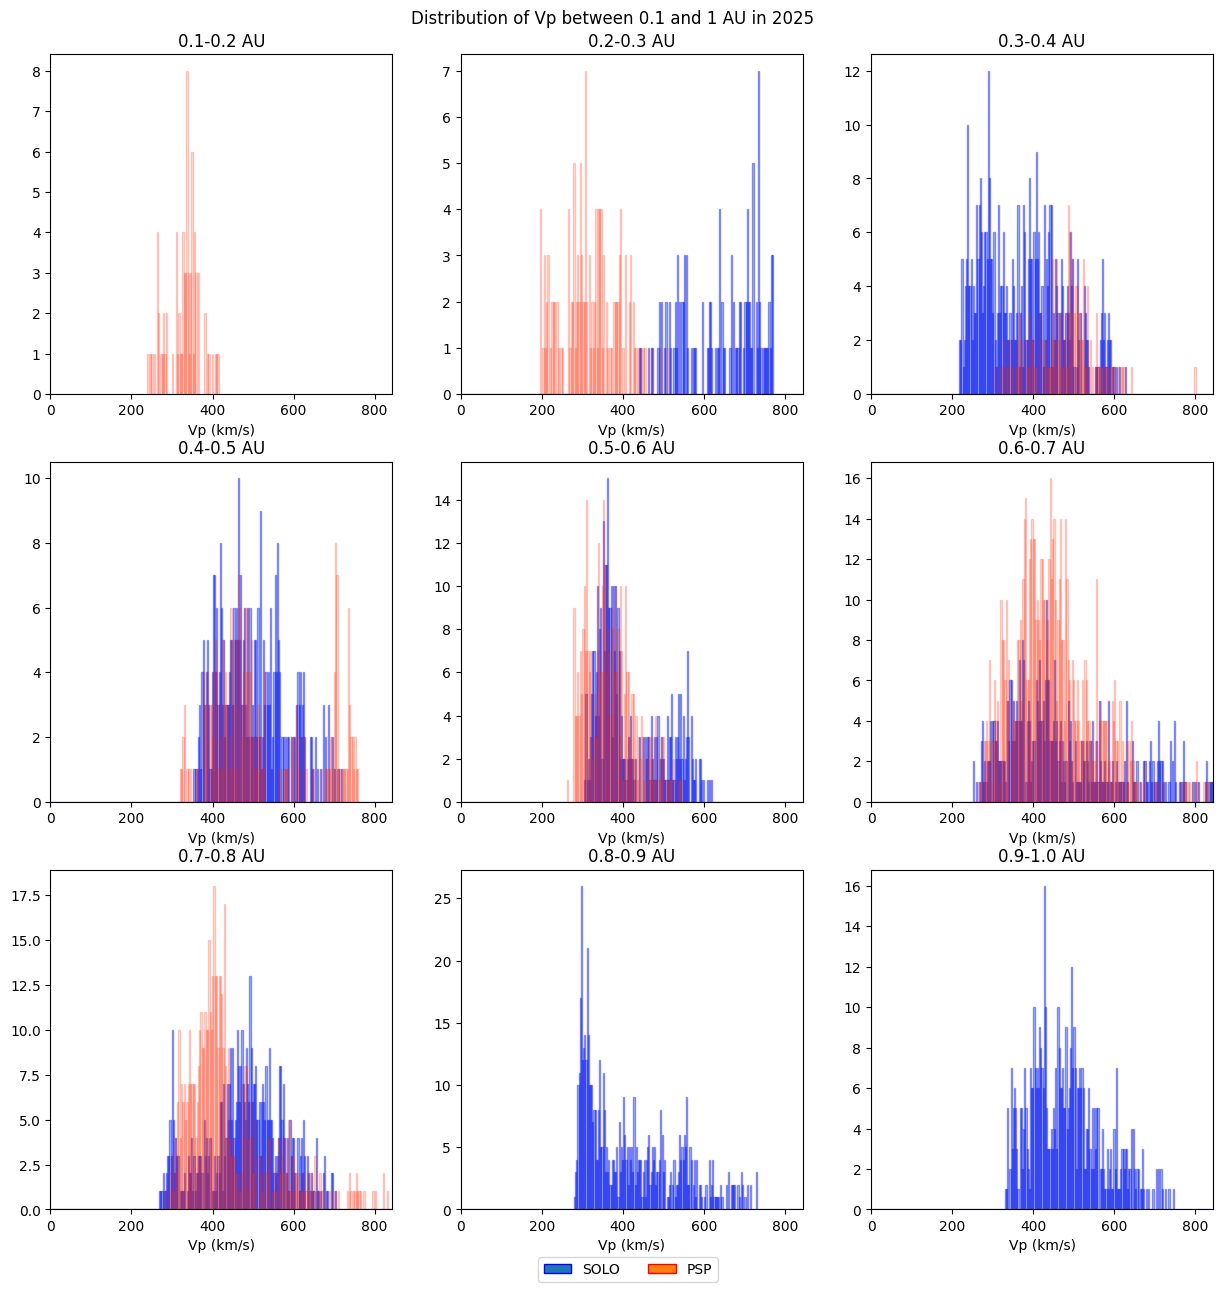

In [13]:
plot_histograms('Vp', 'km/s', year=2025)

# Find spacecraft positions when SOLO detects 600 kms wind speed at .2 AU

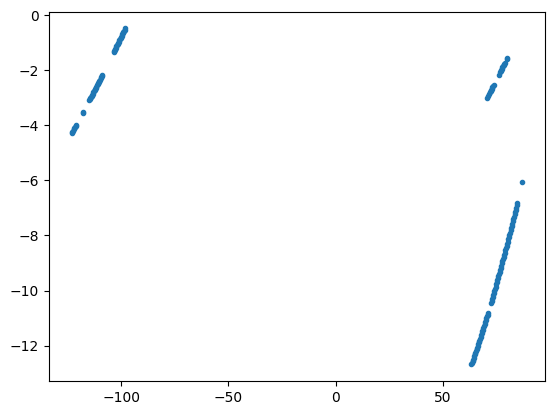

In [18]:
solo = create_ds('solo')
psp = create_ds('psp')

# Filter by distance and wind speed
dist_lim = (.2, .3)
vp_min = 600

solo = solo[(dist_lim[0] <= solo['Distance']) & (solo['Distance'] <= dist_lim[1]) & (vp_min <= solo['Vp'])]

plt.plot(solo['lon'], solo['lat'], '.')

In [19]:
solo.columns

Index(['Half_interval', 'Info', 'Np', 'P_RTN_0', 'P_RTN_1', 'P_RTN_2',
       'P_RTN_3', 'P_RTN_4', 'P_RTN_5', 'P_SRF_0', 'P_SRF_1', 'P_SRF_2',
       'P_SRF_3', 'P_SRF_4', 'P_SRF_5', 'SCET', 'Tp', 'TxTyTz_RTN_0',
       'TxTyTz_RTN_1', 'TxTyTz_RTN_2', 'TxTyTz_SRF_0', 'TxTyTz_SRF_1',
       'TxTyTz_SRF_2', 'V_RTN_0', 'V_RTN_1', 'V_RTN_2', 'V_SOLO_RTN_0',
       'V_SOLO_RTN_1', 'V_SOLO_RTN_2', 'V_SRF_0', 'V_SRF_1', 'V_SRF_2',
       'quality_factor', 'total_count', 'unrecovered_count', 'Vp', 'B_r',
       'B_t', 'B_n', 'QUALITY_BITMASK', 'QUALITY_FLAG', 'VECTOR_RANGE',
       'VECTOR_TIME_RESOLUTION', 'total_B', 'Distance', 'lon', 'lat'],
      dtype='object')

# Magnetic Field vs Wind Speed

In [ ]:
def mag_vs_vp(sc_name, year=None, dist_lim=(0, 1)):
    
    dist_min, dist_max = dist_lim

    sc = create_ds(sc_name, year)

    sc = sc[(sc['Distance'] <= dist_max) & (sc['Distance'] >= dist_min)]

    fig, ax = plt.subplots(4, figsize=(7, 15), dpi=100)

    if sc_name == 'solo':
        color = 'tab:blue'
    else:
        color = 'tab:red'

    for aa, param in zip(ax, ['total_B', 'B_r', 'B_t', 'B_n']):

        aa.plot(sc['Vp'], sc[f'{param}'], '.', alpha=.3, color=color)
        aa.set_xlabel('Vp (km/s)')
        aa.set_ylabel(f'{param} (nT)')
        aa.xaxis.set_tick_params(direction='in')
        aa.set_xlim(0, 1000)

    if year:
        fig.suptitle(f'B-field vs wind speed, {sc_name.upper()} data between {dist_min}-{dist_max} AU in {year}', y=0.90)
    else:
        fig.suptitle(f'B-field vs wind speed, {sc_name.upper()} data between {dist_min}-{dist_max} AU', y=0.90)

    plt.subplots_adjust(hspace=0)

    return fig, ax

0.00-0.10 AU
0.10-0.20 AU
0.20-0.30 AU
0.30-0.40 AU
0.40-0.50 AU
0.50-0.60 AU
0.60-0.70 AU
0.70-0.80 AU
0.80-0.90 AU
0.90-1.00 AU
0.00-0.10 AU
0.10-0.20 AU
0.20-0.30 AU
0.30-0.40 AU
0.40-0.50 AU
0.50-0.60 AU
0.60-0.70 AU
0.70-0.80 AU
0.80-0.90 AU
0.90-1.00 AU


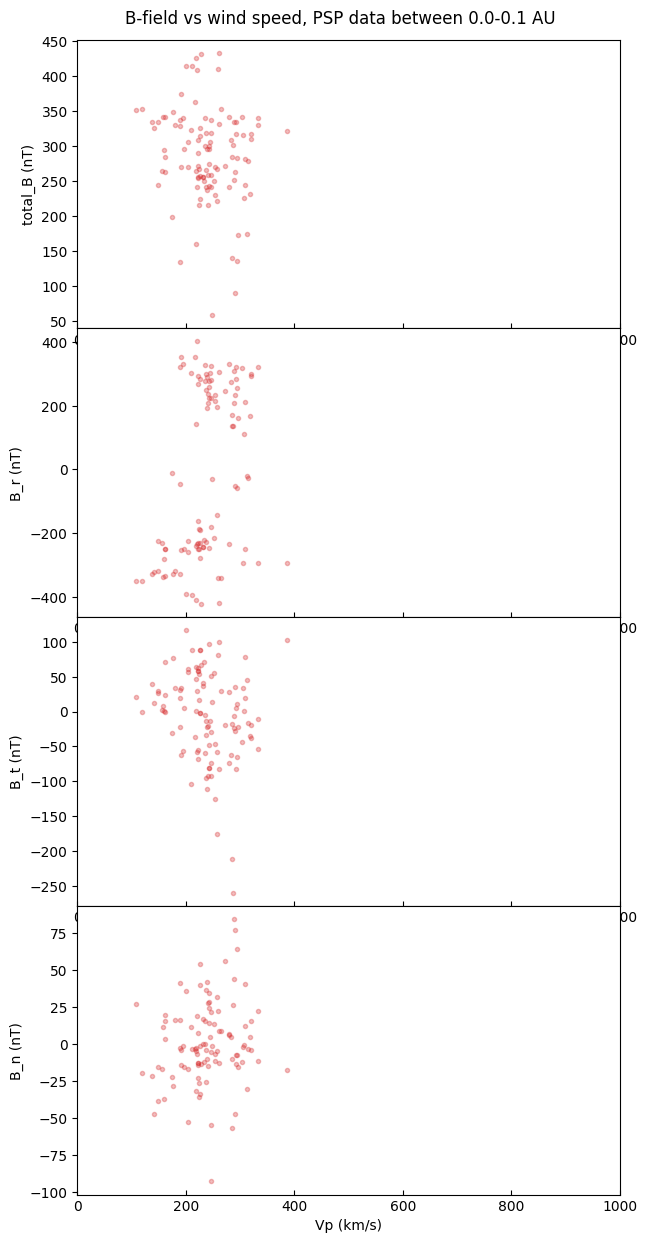

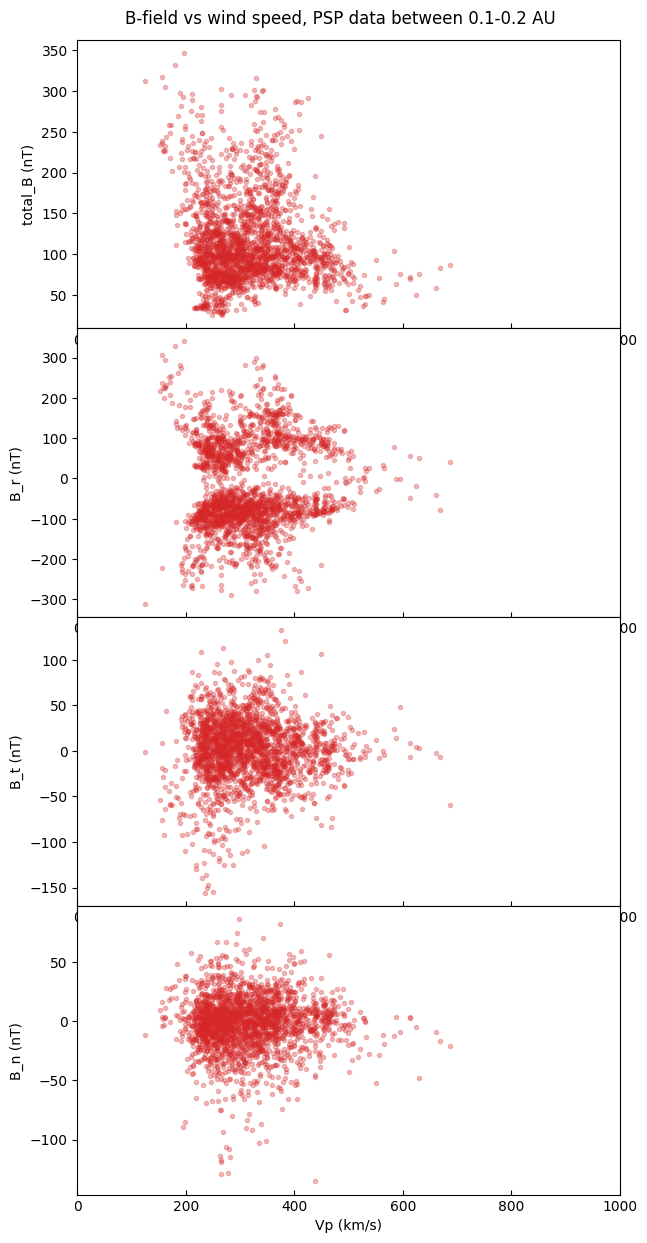

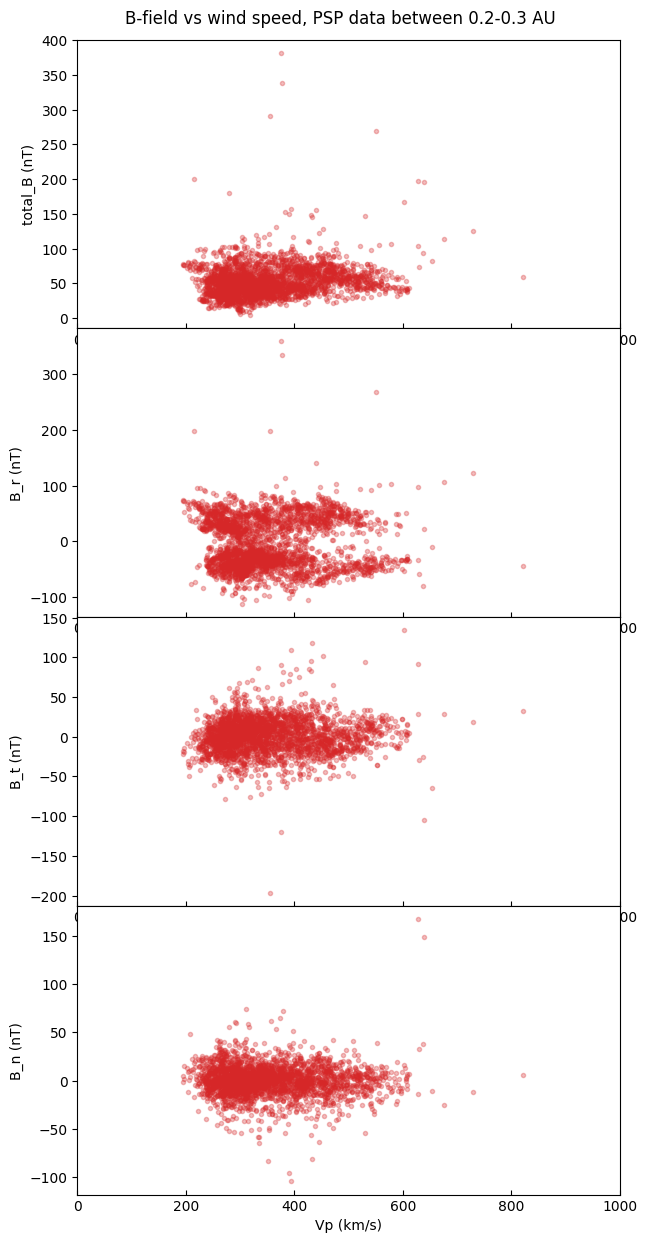

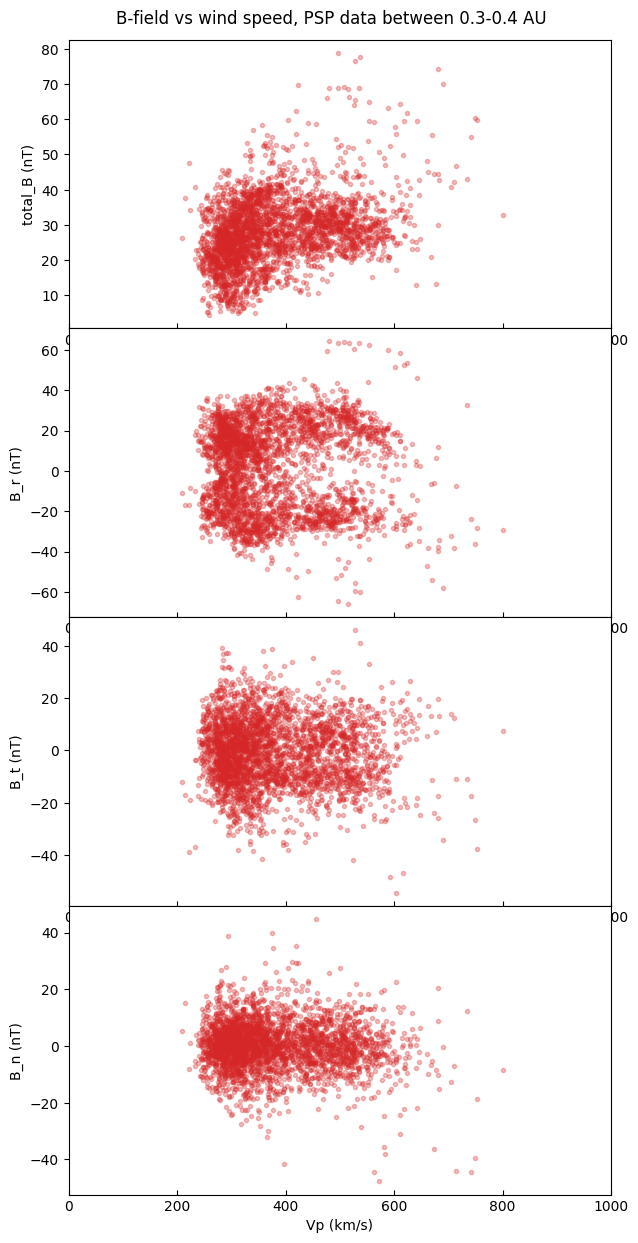

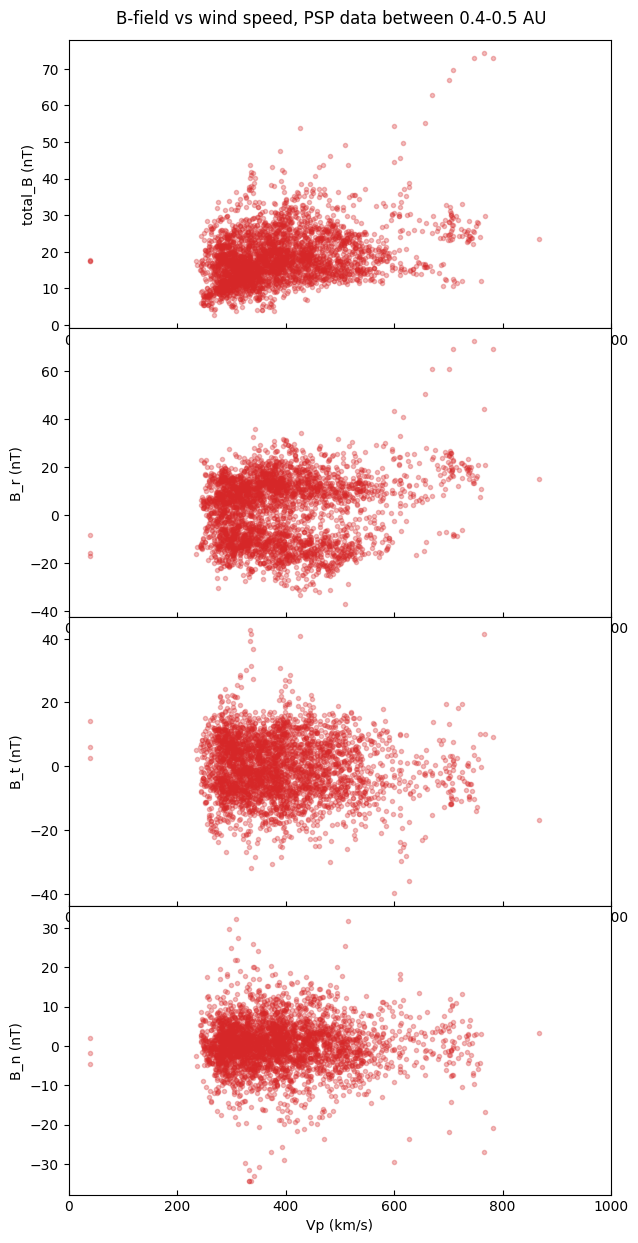

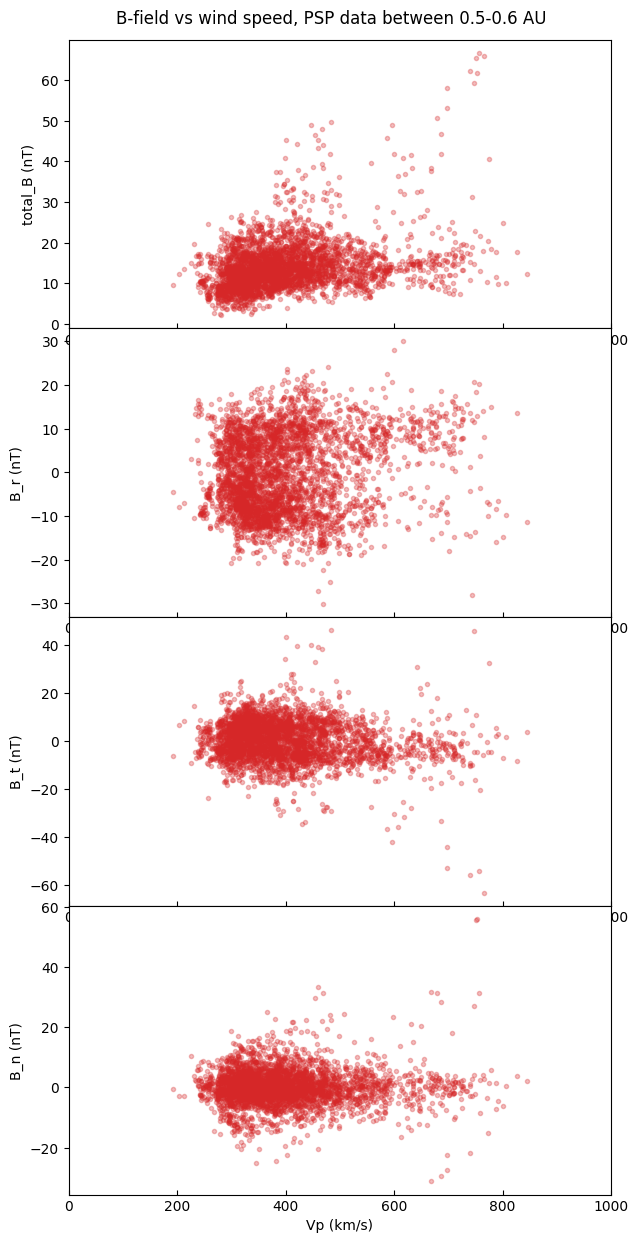

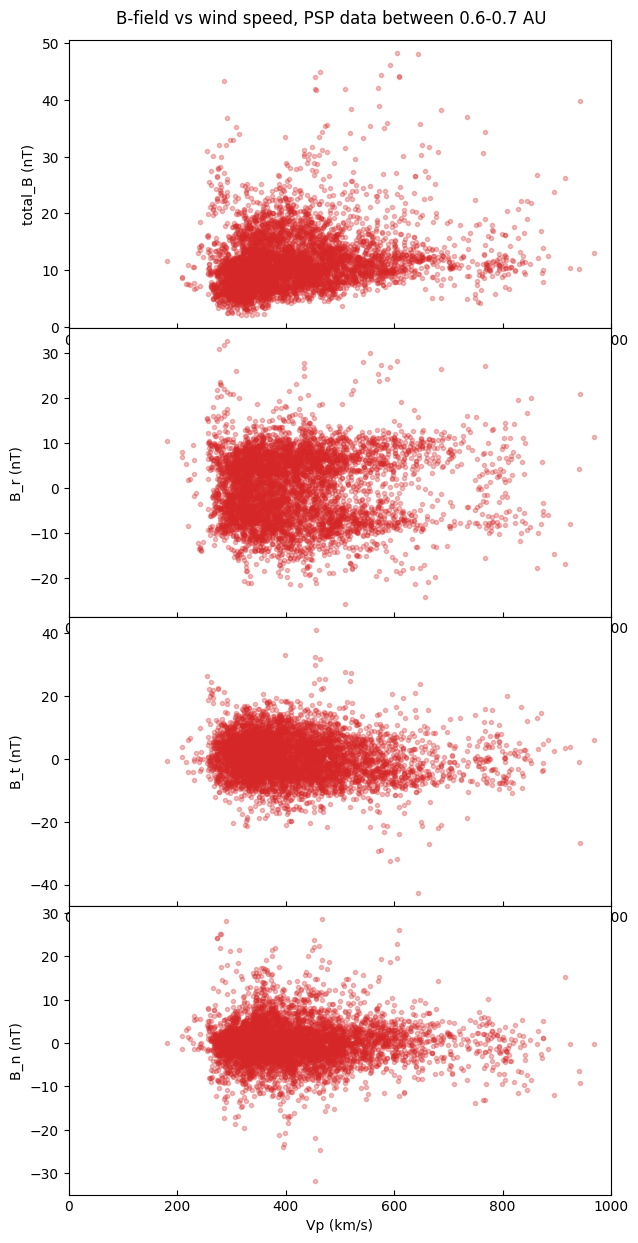

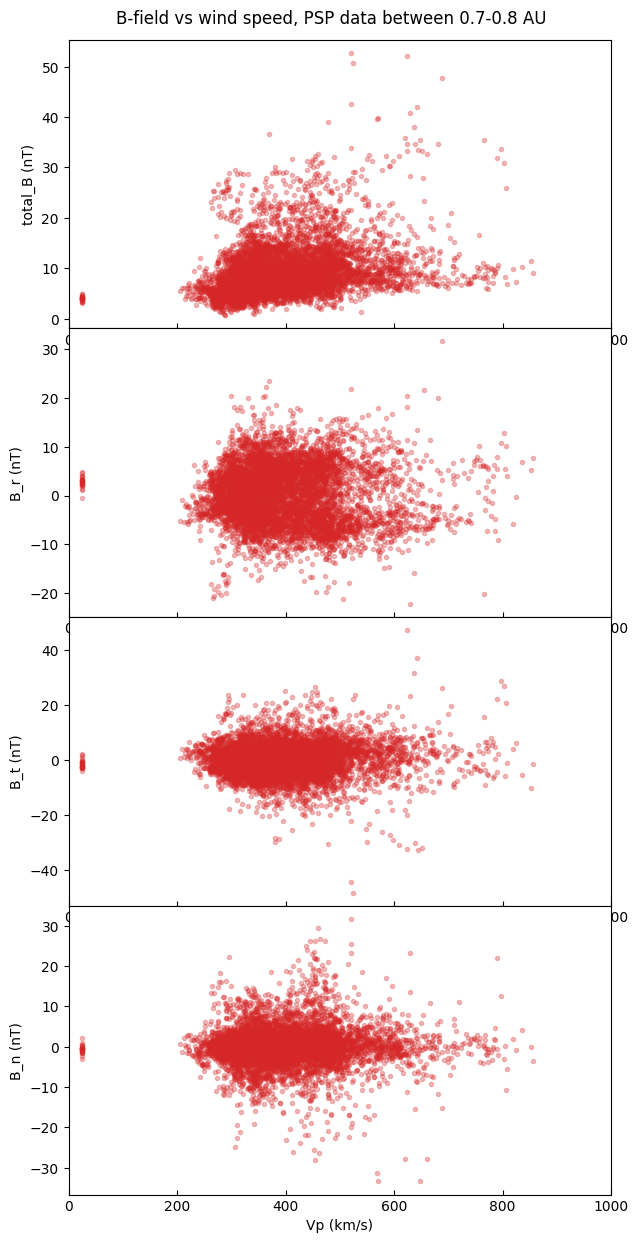

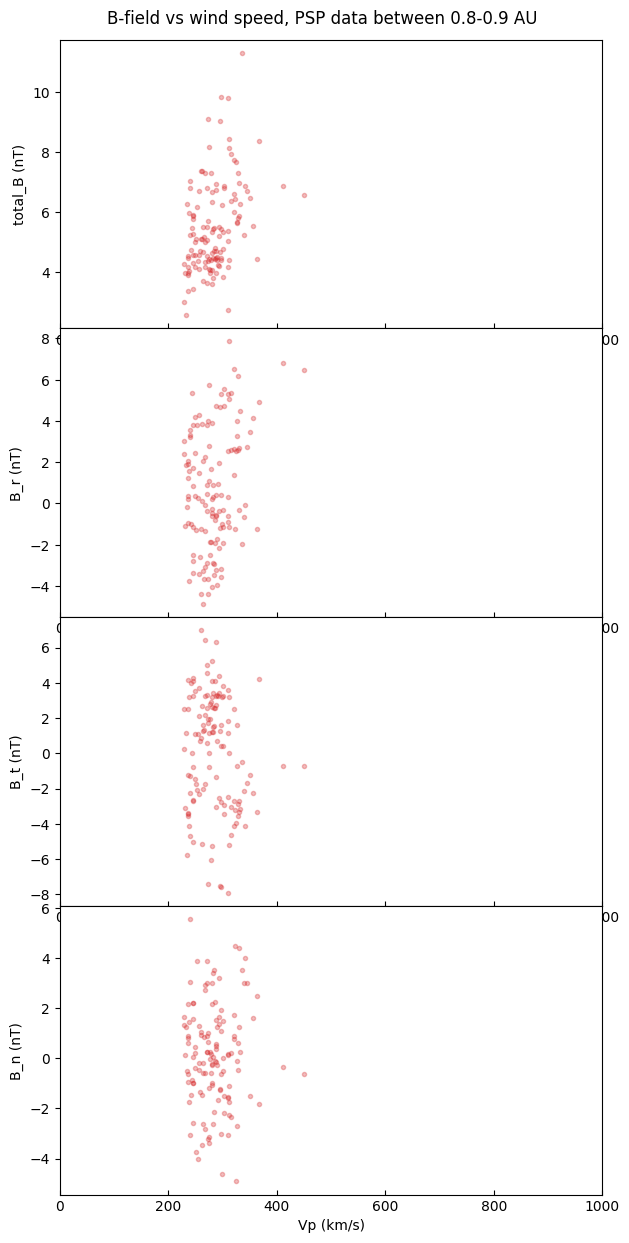

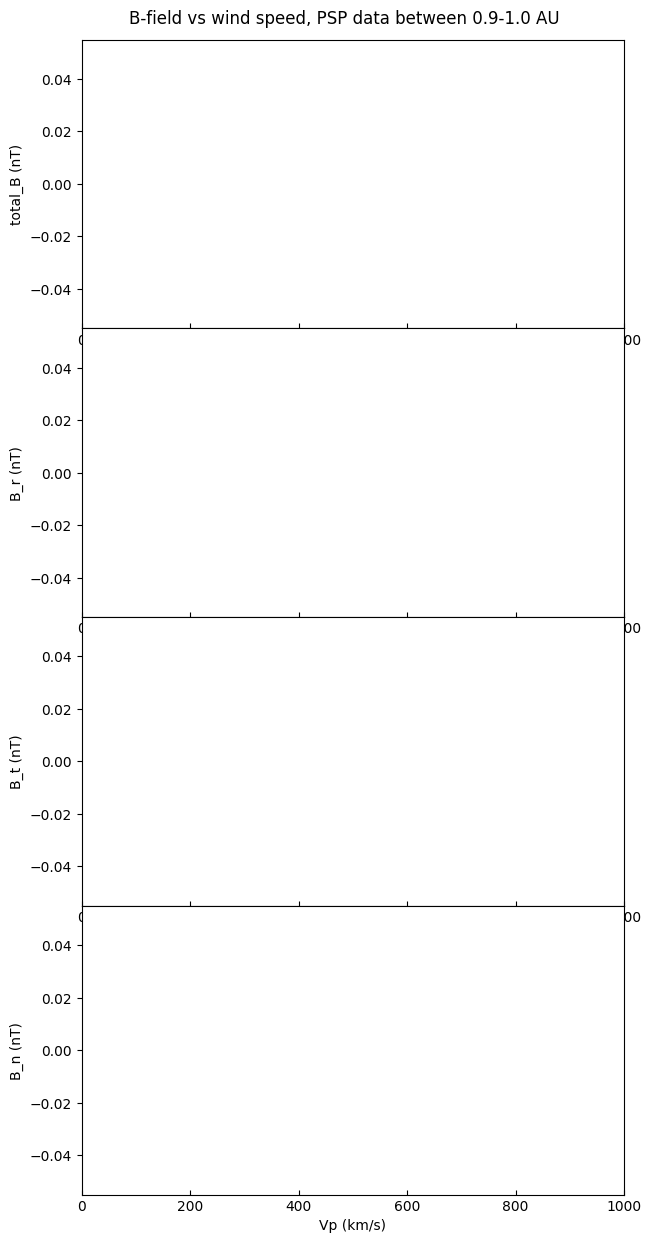

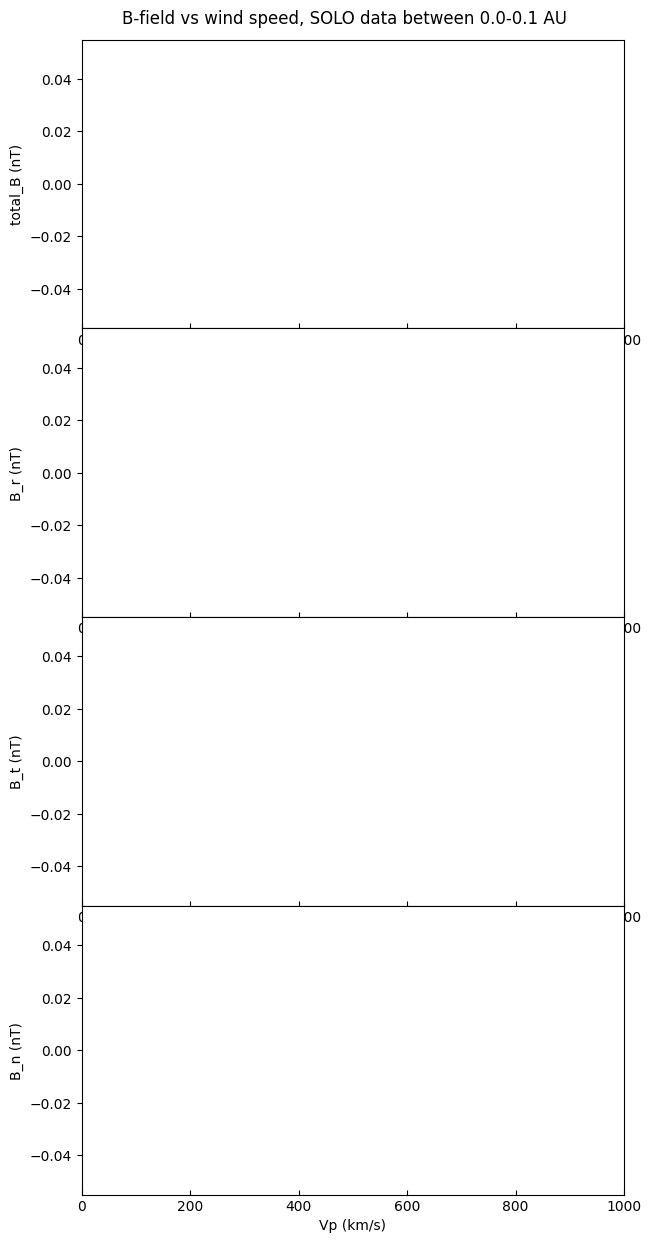

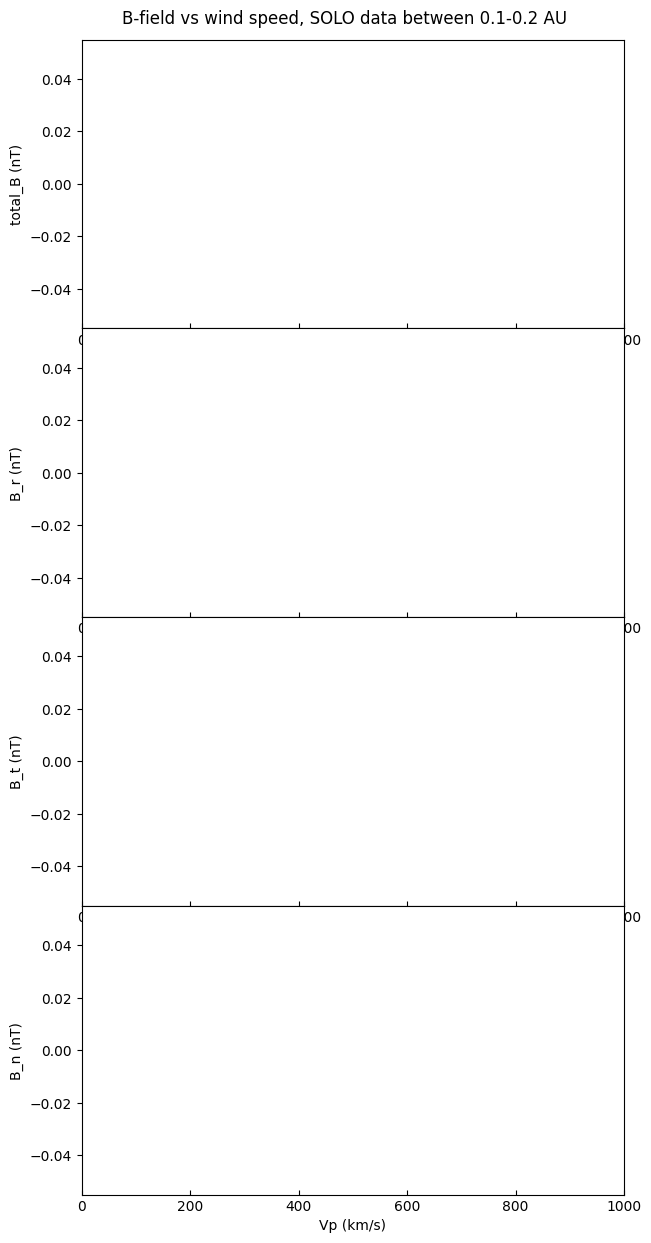

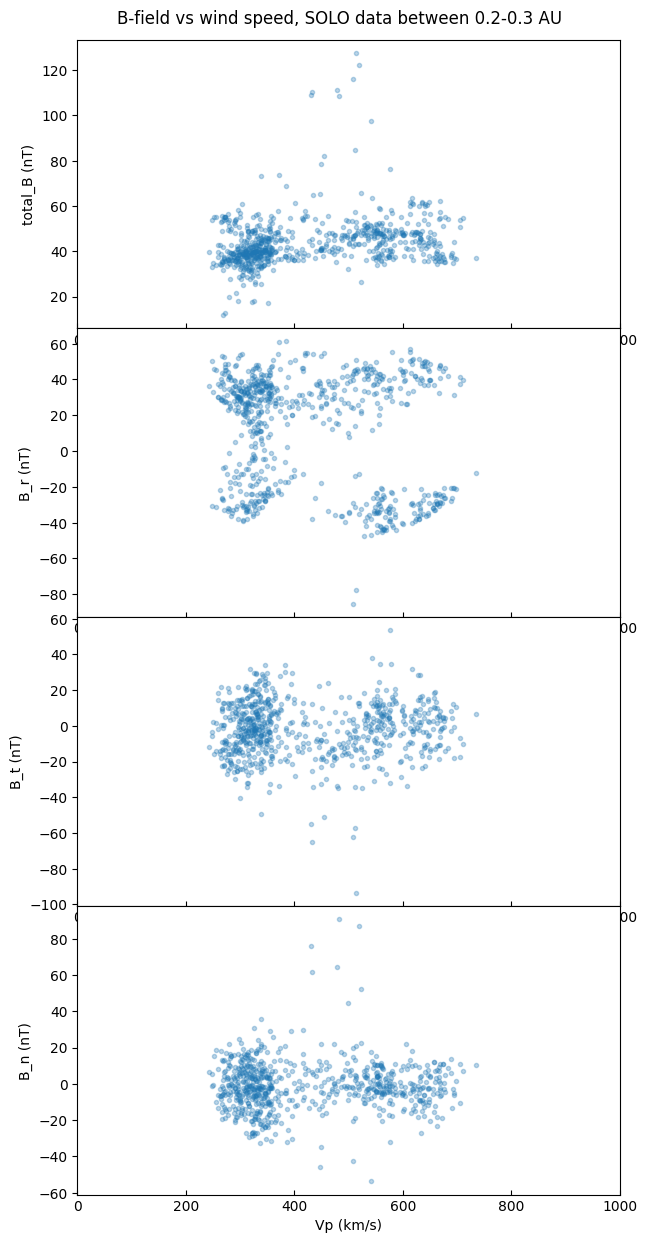

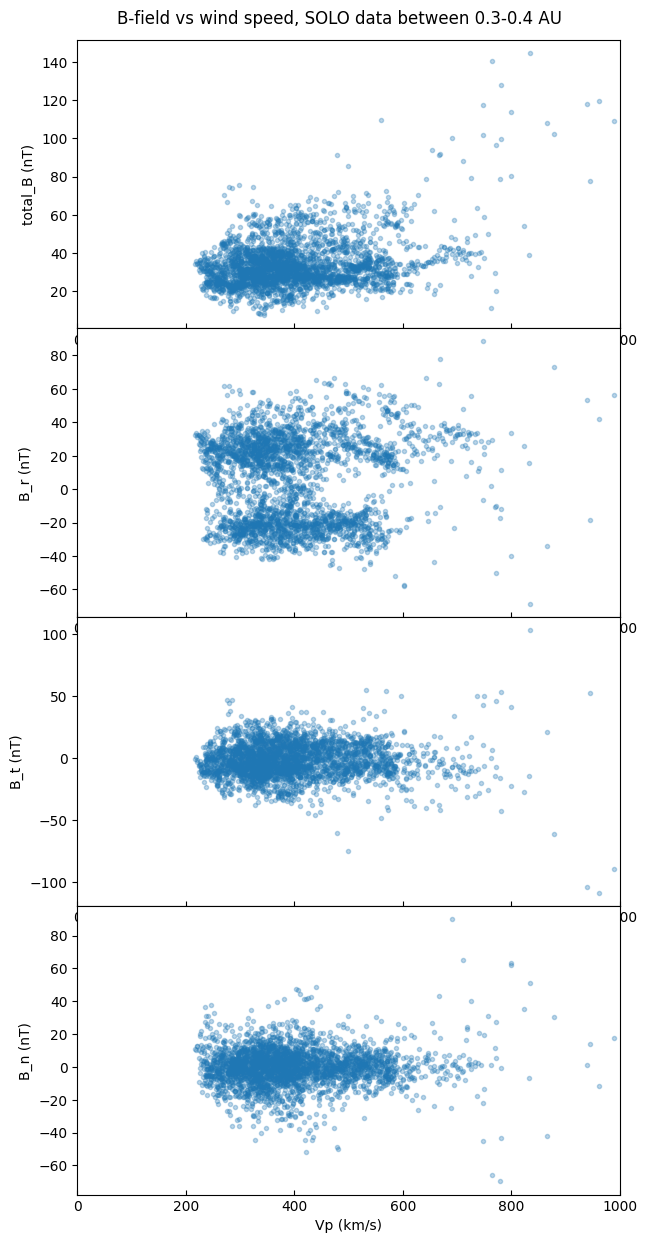

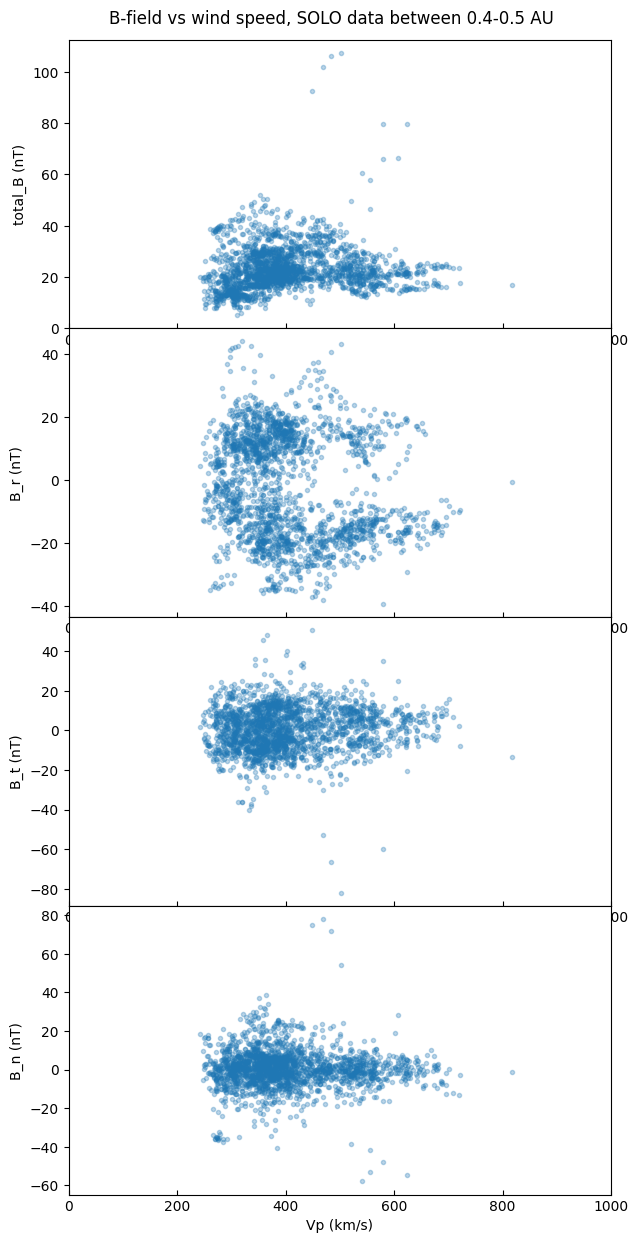

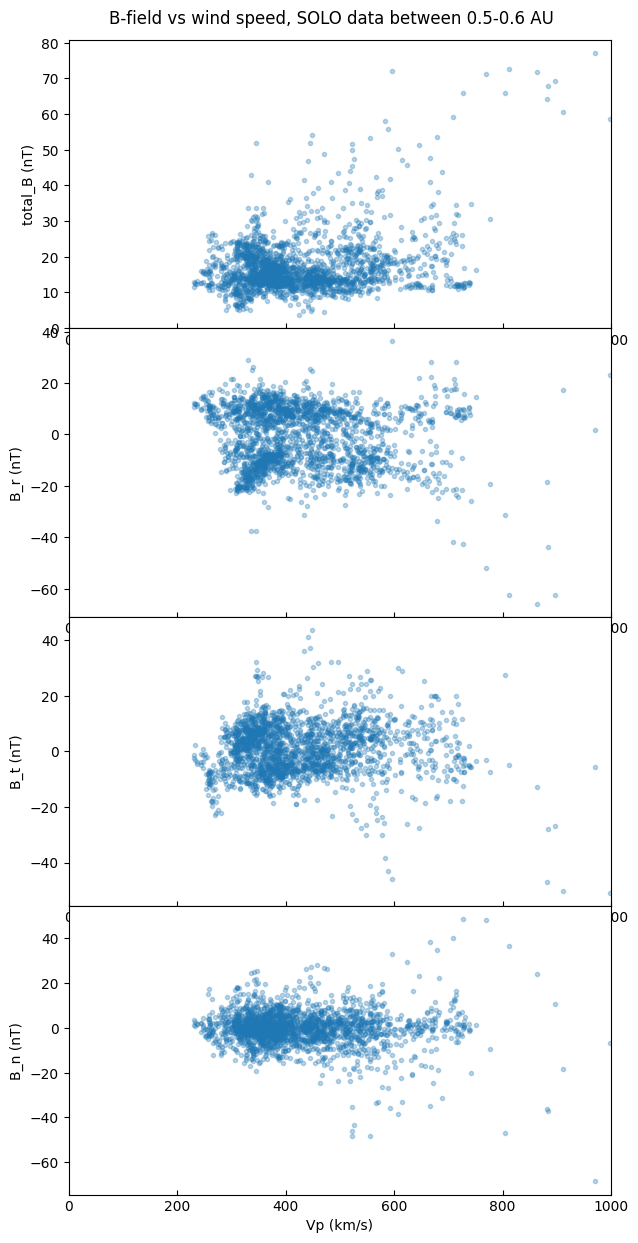

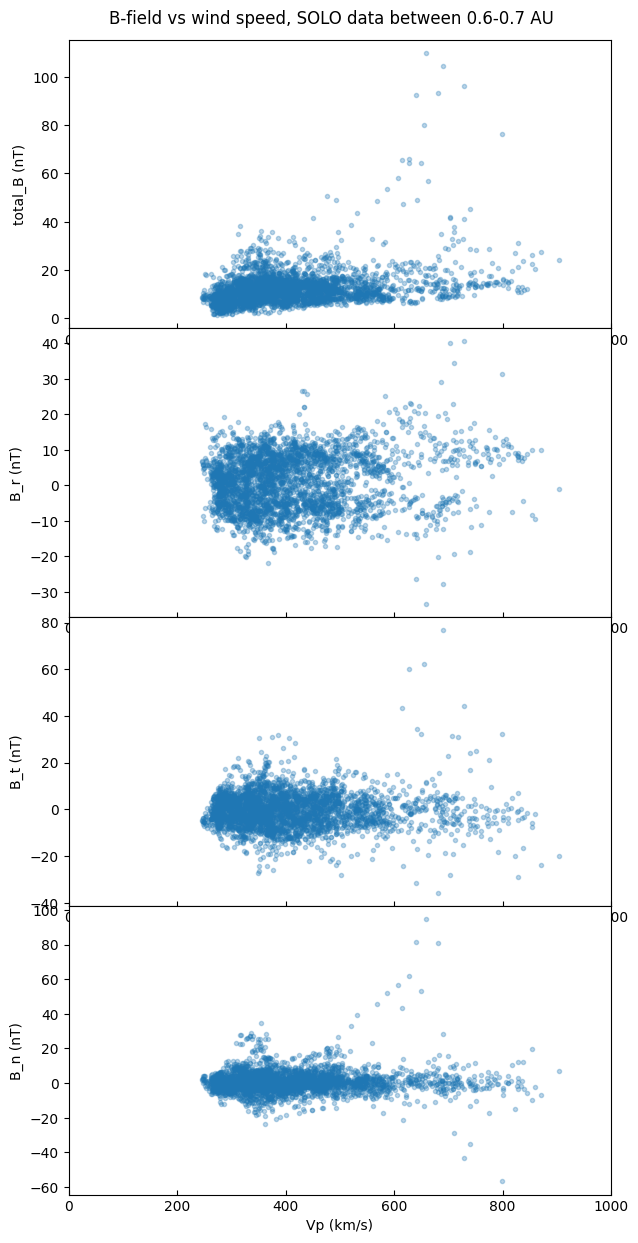

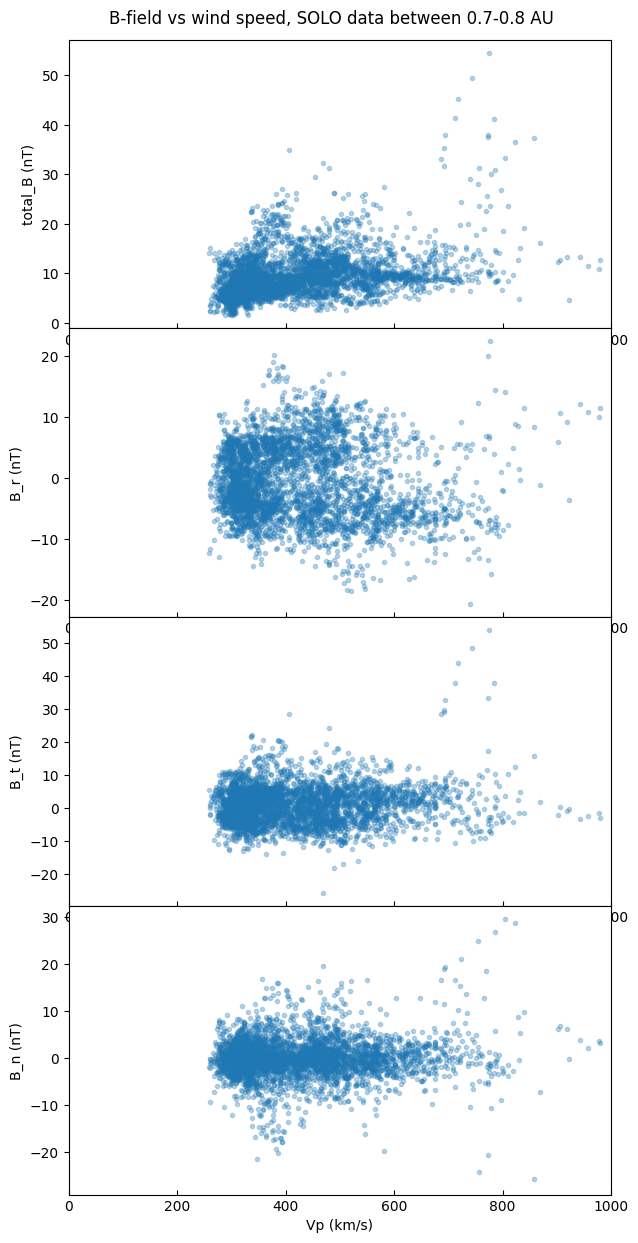

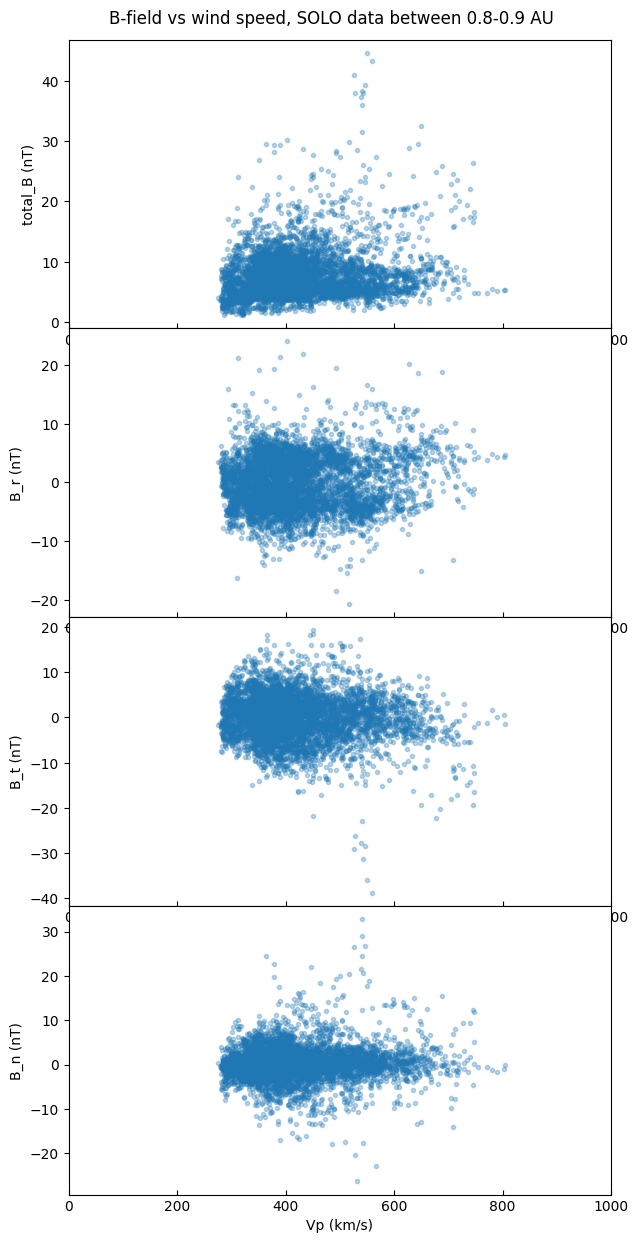

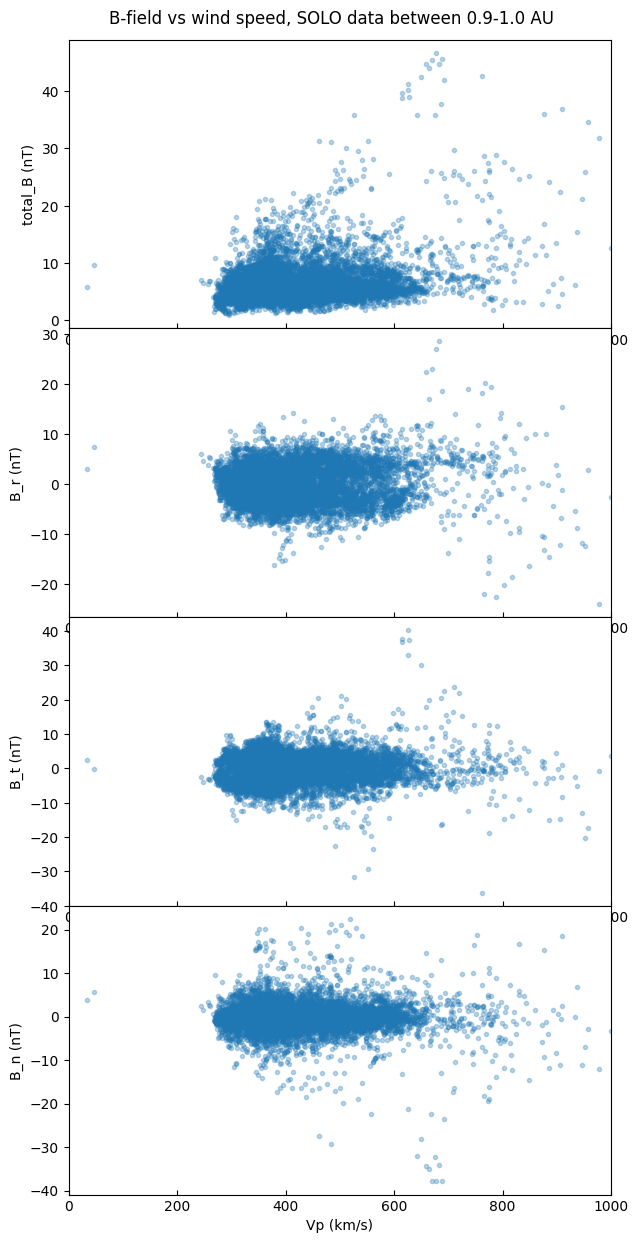

In [ ]:
for sc_name in ['psp', 'solo']:
    for i in np.arange(0, 1, 0.1):
        dist_lim = (round(i, 1), round(i+.1, 1))
        mag_vs_vp(sc_name, dist_lim=dist_lim)
        print(f'{dist_lim[0]:.2f}-{dist_lim[1]:.2f} AU')

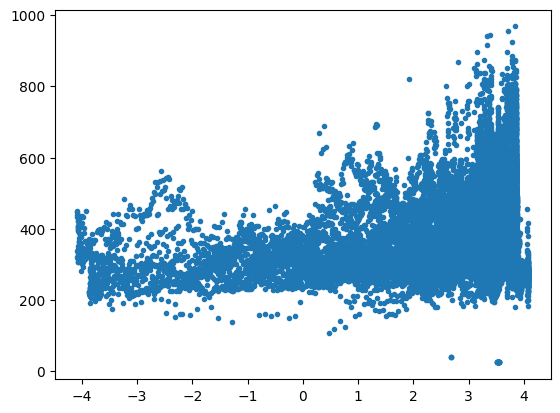

In [ ]:
psp = create_ds('psp')

plt.plot(psp['lat'], psp['Vp'], '.')